## Simple circuit models for Solar Cells

In this notebook, we want to calculate the properties of various solar cell models. We will be focused on the single diode model, and making slight adaptations to see what happens.

We will be using numpy and scipy libraries to do some math, matplotlib for our plotting and the SchemDraw module in order to draw the circuit diagram.

In our first block of code, we get everything set up, and load all of the modules

In [1]:
# Import Modules
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import SchemDraw as schem
import SchemDraw.elements as e
%matplotlib inline

# We want to use TeX to format graph labels
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

## Ideal Solar Cell Model

An ideal solar cell can be modeled as a diode in parallel with a current source. The current source comes light be absorbed by the solar cell. As the photons are absorbed, they create electron-hole pairs. The diode serves to separate the charges.

Circuit diagram for the ideal solar cell is given below using the SchemDraw Package

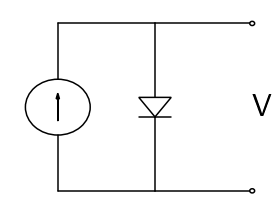

In [2]:
d = schem.Drawing(fontsize = 32)  # unit=2 makes elements with shorter than normal leads
d.push()
Isrc = d.add(e.SOURCE_I, d='down', l=3,zoom=2)
d.add(e.LINE, d='right')
d.pop()
d.add(e.LINE, d='right')
d.push()
D = d.add(e.DIODE, d='down', l=3, zoom=2)
d.add(e.LINE, d='right')
d.add(e.DOT_OPEN)
d.pop()
d.add(e.LINE, d='right')
d.add(e.DOT_OPEN)
d.add(e.GAP_LABEL, d='down', label='V', l=3, zoom=2)
d.draw()
d.save('ideal_diode.png')

img = mpimg.imread('ideal_diode.png')


We want to look more in detail at the behavior of this circuit. The current-voltage relation is given by

$$ I = I_{sc} + I_{0}\left( \exp \left( \frac{qV}{mkT} \right) - 1 \right)$$
where $I_{sc}$ is the short circuit current, $I_{0}$ is the diode recombination current and $m$ is the ideality factor. $m = 1$ corresponds to an ideal solar cell.

We define something called the local ideality factor, which is given by

$$ m = \frac{q}{kT} \left[ \frac{dV}{d \ln I}\right] = \frac{qI}{kT}\frac{dV}{dI} $$

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel\__main__.py:28: RuntimeWarning: divide by zero encountered in log


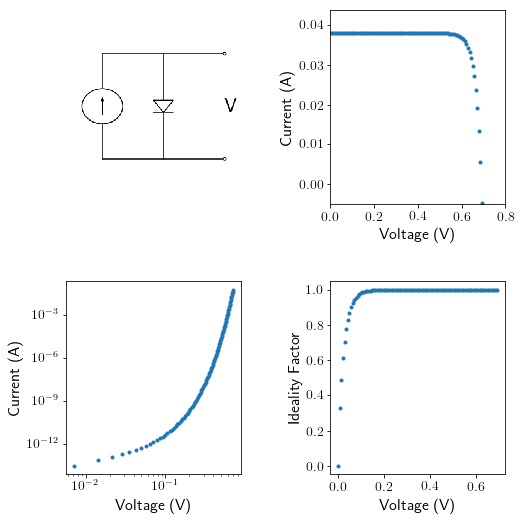

In [3]:
# Start by defining useful constants
k = 1.38e-23
T = 300
q = 1.6e-19
kT = k*T
Vt = kT/q

# Physical Parameters - We are choosing parameters to line up with Figure 2.4 in Keith McIntosh's thesis, Humps, Lumps and Bumps.
Isc = .038
I0 = 1.0e-13
n = 1.0

# We are using Ideal solar cell model right now, but later we will want to look at effects of series
# and shunt resistance, so we define them here

Rs = 1.0
Rsh = 1.0e6

# Define the voltage range at which we are interested in looking
Vmin = 0.0
Vmax = 0.7
nsamp = 100
V = np.linspace(Vmin, Vmax, nsamp)

# Calculate the measured current as a function of the bias voltage
def calc_idealdiode(V, Isc, I0, n):
    I = Isc - I0*(np.exp(V/(n*Vt)) - 1)
    m = (1/Vt)*np.diff(V)/np.diff(np.log(abs(I-Isc)))
    return V, I, m

[V, I, m] = calc_idealdiode(V, Isc, I0, n)


# Define plotting function


def plot_IV(V, I, m, img):
    ls = 14
    fs = 16
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(221)
    plt.axis('off')
    ax.imshow(img)
    ax.tick_params(labelsize=ls)
    bx = fig.add_subplot(222)
    bx.set_xlabel('Voltage (V)', fontsize=fs)
    bx.set_ylabel('Current (A)$', fontsize=fs)
    bx.set_ylim(-.005,1.15*max(I))
    bx.set_xlim(0,0.8)
    bx.tick_params(labelsize=ls)
    bx.plot(V, I, '.')
    cx = fig.add_subplot(223)
    cx.loglog(V, abs(I-max(I)),'.')
    cx.set_xlabel('Voltage (V)', fontsize=fs)
    cx.set_ylabel('Current (A)$', fontsize=fs)
    cx.tick_params(labelsize=ls)
    dx = fig.add_subplot(224)
    dx.plot(V[0:-1],m, '.')
    dx.set_xlabel('Voltage (V)', fontsize=fs)
    dx.tick_params(labelsize=ls)
    dx.set_ylabel('Ideality Factor', fontsize=fs)
    plt.tight_layout()
    
plot_IV(V, I, m, img)

## Solar cell with Shunt resistance
Real solar cells suffer resistive losses. These losses can be summarized by adding a resistance in parallel with diode and current source, called the shunt resistance, $R_{sh}$. Then all three current paths are placed in series with another resistance called the series resistance, $R_{s}$.

Including the $R_{s}$ value means we will have to solve a transcendental equation (and we will need to look into some rootfinding methods.

So we will start by setting $R_{s} = 0\ \Omega$

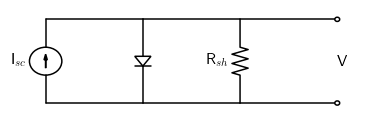

In [4]:
d = schem.Drawing()  # unit=2 makes elements with shorter than normal leads
d.push()
Isrc = d.add(e.SOURCE_I, d='down', label=r'I_{sc}')
d.add(e.LINE, d='right')
d.pop()
d.add(e.LINE, d='right')
d.push()
D = d.add(e.DIODE, d='down')
d.add(e.LINE, d='right')
d.pop()
d.add(e.LINE, d='right')
d.push()
d.add(e.RES, d='down', label=r'R_{sh}')
d.add(e.LINE, d='right')
d.add(e.DOT_OPEN)
d.pop()
d.add(e.LINE, d='right')
d.add(e.DOT_OPEN)
d.add(e.GAP_LABEL, d='down', label='V')
d.draw()
d.save('single_diode_shunt.png')

img2 = mpimg.imread('single_diode_shunt.png')

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel\__main__.py:8: RuntimeWarning: divide by zero encountered in log


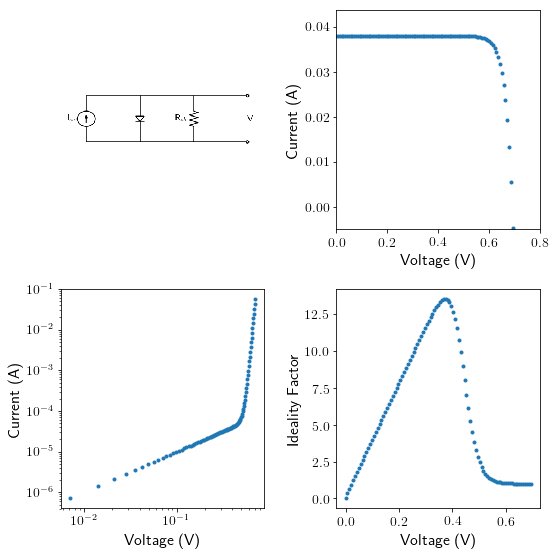

In [5]:
# Still plotting over same range as above

R_sh = 1.0e4 # ohms


def calc_Ish(V, Isc, I0, n, Rsh):
    I = Isc - I0*(np.exp(V/Vt) - 1) - V/R_sh
    m = (1/Vt)*np.diff(V)/np.diff(np.log(abs(I-Isc)))
    return V, I, m

V, Ish, msh = calc_Ish(V, Isc, I0, n, Rsh)

plot_IV(V, Ish, msh, img2)

## Solar cell with series and shunt resistance¶

We want to add in the effect of a series resistance. This series resistance makes calculations harder, because now, in order to find the current we need to solve a transcendental equation. Below we have the circuit diagram:

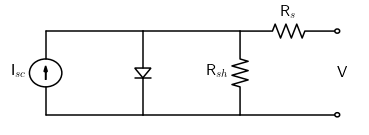

In [6]:
d = schem.Drawing()  # unit=2 makes elements with shorter than normal leads
d.push()
Isrc = d.add(e.SOURCE_I, d='down', label=r'I_{sc}')
d.add(e.LINE, d='right')
d.pop()
d.add(e.LINE, d='right')
d.push()
D = d.add(e.DIODE, d='down')
d.add(e.LINE, d='right')
d.pop()
d.add(e.LINE, d='right')
d.push()
d.add(e.RES, d='down', label=r'R_{sh}')
d.add(e.LINE, d='right')
d.add(e.DOT_OPEN)
d.pop()
d.add(e.RES, d='right', label=r'R_{s}')
d.add(e.DOT_OPEN)
d.add(e.GAP_LABEL, d='down', label='V')
d.draw()
d.save('single_diode_shuntseries.png')

img3 = mpimg.imread('single_diode_shuntseries.png')

Then the current flowing through the circuit is given as

$$ I = I_{sc} + I_{D} + I_{sh}$$$$ I = I_{sc} - I_{0}\left( \exp \left( \frac{q(V-IR_{s})}{nkT}\right) - 1 \right) - \frac{V - IR_{s}}{R_{sh}}$$
This is a transcendental equation. It will have to solved using numerical techniques.

Define

$$ Z(I) = I_{sc} - I_{0}\left( \exp \left( \frac{q(V-IR_{s})}{nkT}\right) - 1 \right) - \frac{V - IR_{s}}{R_{sh}} - I $$
Finding the roots of $Z$ will give the current $I$. Below, we can look at a plot of $Z$ to get an idea of how to find the roots

(-1, 1)

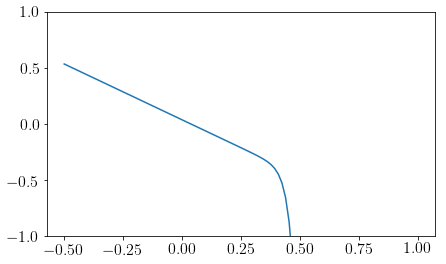

In [7]:
Rs = 1.0

def Z(I,V):
    return Isc - I0*(np.exp((V+I*Rs)/Vt) - 1) - (V + I*Rs)/Rsh - I
    
v = 0.3

Itest = np.linspace(-0.5,1.0,100)
z = Z(Itest,v)

plt.plot(Itest,z)
plt.ylim(-1,1)

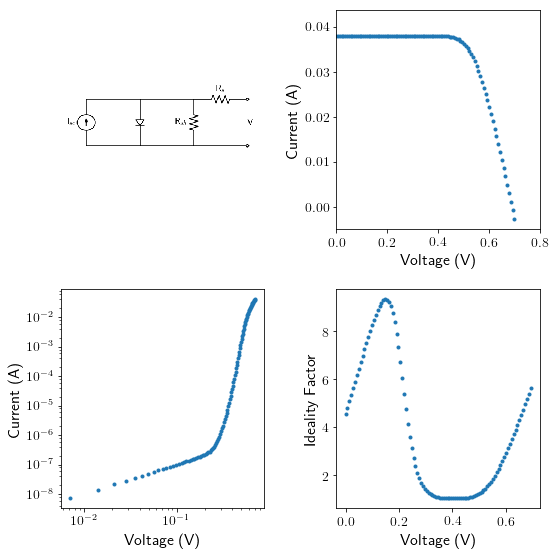

In [8]:
Rs = 3.0


def calc_Iguess(V, Isc, I0, n, Rsh, Rs):
    return V/Rs - (Vt/Rs)*np.log((Vt/(I0*Rs))*(1-Rs/Rsh)) + 1e-2


def calc_Is(V, Isc, I0, n, Rsh, Rs):
    # Define implicit function to calculate I
    def f(I,V):
        return Isc - I0*(np.exp((V+I*Rs)/Vt) - 1) - (V + I*Rs)/Rsh - I
    # Derivative
    def dfdI(I,V):
        return -I0*np.exp((V+I*Rs)/Vt)*(Rs/Vt) - Rs/Rsh - 1
    
    # Calculate initial guesses
    #V, Ish, msh = calc_Ish(V, Isc, I0, n, Rsh)
    # start calculating I
    I = []
    for i, v in enumerate(V):
        Iguess = calc_Iguess(v, Isc, I0, n, Rsh, Rs)
        I.append(fsolve(f, Iguess, args=v)[0])
    I = np.array(I)
    m = (1/Vt)*np.diff(V)/np.diff(np.log(abs(I-Isc)))
    return V, I, m

V, Is, ms = calc_Is(V, Isc, I0, n, Rsh, Rs)
    
#print(Isc - I0*(np.exp((V-Is*Rs)/Vt) - 1) - (V - Is*Rs)/Rsh - Is)
    
plot_IV(V, Is, ms, img3)

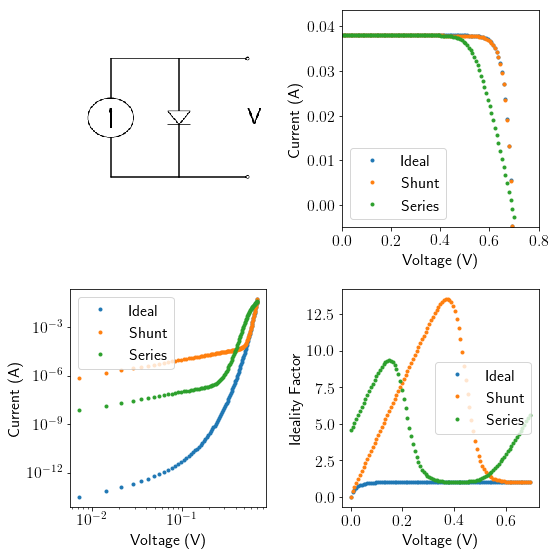

In [9]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(221)
plt.axis('off')
ax.imshow(img)
bx = fig.add_subplot(222)
bx.set_xlabel('Voltage (V)')
bx.set_ylabel('Current (A)$')
bx.set_ylim(-.005,1.15*Isc)
bx.set_xlim(0,0.8)
bx.plot(V, I, '.', label='Ideal')
bx.plot(V, Ish, '.', label='Shunt')
bx.plot(V, Is, '.', label='Series')
bx.legend()
cx = fig.add_subplot(223)
cx.loglog(V, abs(I-max(I)),'.', label='Ideal')
cx.loglog(V, abs(Ish-max(Ish)),'.', label='Shunt')
cx.loglog(V, abs(Is-max(Is)),'.', label='Series')
cx.set_xlabel('Voltage (V)')
cx.set_ylabel('Current (A)$')
cx.legend()
dx = fig.add_subplot(224)
dx.plot(V[0:-1],m, '.', label='Ideal')
dx.plot(V[0:-1],msh, '.', label='Shunt')
dx.plot(V[0:-1],ms, '.', label='Series')
dx.set_xlabel('Voltage (V)')
dx.set_ylabel('Ideality Factor')
dx.legend()
plt.tight_layout()

## Double diode model

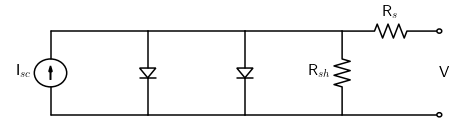

In [10]:
d = schem.Drawing()  # unit=2 makes elements with shorter than normal leads
d.push()
Isrc = d.add(e.SOURCE_I, d='down', label=r'I_{sc}')
d.add(e.LINE, d='right')
d.pop()
d.add(e.LINE, d='right')
d.push()
D = d.add(e.DIODE, d='down')
d.add(e.LINE, d='right')
d.pop()
d.add(e.LINE, d='right')
d.push()
d.add(e.DIODE, d='down')
d.add(e.LINE, d='right')
d.pop()
d.add(e.LINE, d='right')
d.push()
d.add(e.RES, d='down', label=r'R_{sh}')
d.add(e.LINE, d='right')
d.add(e.DOT_OPEN)
d.pop()
d.add(e.RES, d='right', label=r'R_{s}')
d.add(e.DOT_OPEN)
d.add(e.GAP_LABEL, d='down', label='V')
d.draw()
d.save('double_diode_shuntseries.png')

img4 = mpimg.imread('double_diode_shuntseries.png')

The first diode represents recombination in the pn junction, while the second diode has a floating ideality factor.

We can write down the current equation as

$$ I = I_{L} - I_{01}\left( \exp \left( \frac{V + IR_{s}}{V_{t}}\right) - 1 \right) - I_{02}\left( \exp \left( \frac{V + IR_{s}}{nV_{t}}\right) - 1 \right) - \frac{V + IR_{s}}{R_{sh}}$$

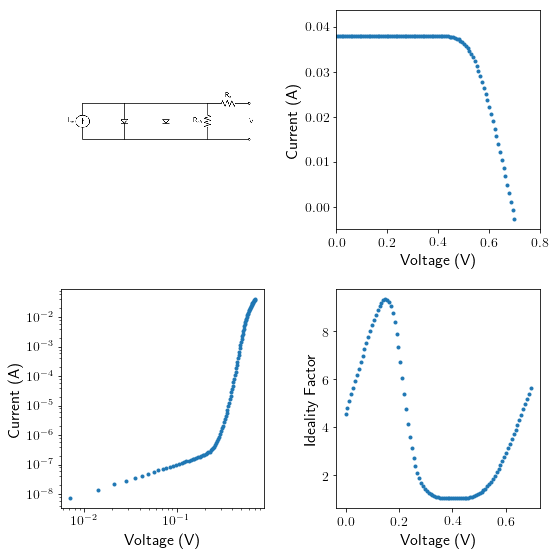

In [17]:
def calc_Idouble(V, Isc, I01, I02, n1, n2, Rsh, Rs):
    # Define implicit function to calculate I
    def f(I,V):
        return Isc - I01*(np.exp((V+I*Rs)/(n1*Vt)) - 1) - I02*(np.exp((V+I*Rs)/(n2*Vt)) - 1) - (V + I*Rs)/Rsh - I
    # Derivative
    def dfdI(I,V):
        return -I0*np.exp((V+I*Rs)/Vt)*(Rs/Vt) - Rs/Rsh - 1
    
    # Calculate initial guesses
    Iguess = Isc - I01*(np.exp(V/(n1*Vt)) - 1) - I02*(np.exp(V/(n2*Vt)) - 1) - V/R_sh
    # start calculating I
    I = []
    for i, v in enumerate(V):
        I.append(fsolve(f, Iguess[i], args=v)[0])
    I = np.array(I)
    m = (1/Vt)*np.diff(V)/np.diff(np.log(abs(I-Isc)))
    return V, I, m

I01 = 1.0e-13
I02 = 5.0e-14
n1 = 1.0
n2 = 2.0

V, Idouble, mdouble = calc_Idouble(V, Isc, I01, I02, n1, n2, Rsh, Rs)

plot_IV(V, Idouble, mdouble, img4)

## Triple diode model

In [ ]:
def calc_Itriple(V, Isc, I01, I02, n1, n2, Rsh, Rs):
    # Define implicit function to calculate I
    def f(I,V):
        return Isc - I01*(np.exp((V+I*Rs)/(n1*Vt)) - 1) - I02*(np.exp((V+I*Rs)/(n2*Vt)) - 1) - (V + I*Rs)/Rsh - I
    # Derivative
    def dfdI(I,V):
        return -I0*np.exp((V+I*Rs)/Vt)*(Rs/Vt) - Rs/Rsh - 1
    
    # Calculate initial guesses
    Iguess = Isc - I01*(np.exp(V/(n1*Vt)) - 1) - I02*(np.exp(V/(n2*Vt)) - 1) - V/R_sh
    # start calculating I
    I = []
    for i, v in enumerate(V):
        I.append(fsolve(f, Iguess[i], args=v)[0])
    I = np.array(I)
    m = (1/Vt)*np.diff(V)/np.diff(np.log(abs(I-Isc)))
    return V, I, m

I01 = 1.0e-13
I02 = 5.0e-14
n1 = 1.0
n2 = 2.0

V, Idouble, mdouble = calc_Idouble(V, Isc, I01, I02, n1, n2, Rsh, Rs)

plot_IV(V, Idouble, mdouble, img4)